In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math

# Fetching Data

In [2]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'FB', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'IBM', 'ORCL', 'CSCO', 'ADBE', 'PYPL', 'QCOM', 'TXN', 'AVGO', 'CRM', 'SAP'
]
start_date = '2019-05-17'
end_date = '2025-05-29'

In [3]:
def download_and_format_stock_data(ticker, start_date, end_date, retries=3):
    for i in range(retries):
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            if not stock_data.empty:
                stock_data.reset_index(inplace=True)
                stock_data['Name'] = ticker
                stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name']]
                stock_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'name']
                return stock_data
        except Exception as e:
            print(f"Attempt {i+1} failed for {ticker}: {e}")
    return pd.DataFrame()

In [4]:
all_stocks_data = pd.concat([download_and_format_stock_data(ticker, start_date, end_date) for ticker in tickers])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

In [5]:
print(all_stocks_data.head())

file_path = 'formatted_stock_data2.csv'
all_stocks_data.to_csv(file_path, index=False)

        date       open       high        low      close     volume  name
0 2019-05-17  44.891462  45.844862  44.850637  45.388577  131516400  AAPL
1 2019-05-20  44.072547  44.271873  43.294456  43.969280  154449200  AAPL
2 2019-05-21  44.480797  45.148416  44.355917  44.812206  113459200  AAPL
3 2019-05-22  44.346330  44.598489  43.839610  43.894844  118994400  AAPL
4 2019-05-23  43.179186  43.356896  42.701284  43.145565  146118800  AAPL


In [6]:
print(f"Data saved to {file_path}")

Data saved to formatted_stock_data2.csv


# EDA

### Data sanity check

In [7]:
print(f"Rows x columns : {all_stocks_data.shape}")
display(all_stocks_data.isna().sum())

Rows x columns : (28804, 7)


date      0
open      0
high      0
low       0
close     0
volume    0
name      0
dtype: int64

### Checking closing prices

In [8]:
close_px = (
    all_stocks_data
    .pivot(index="date", columns="name", values="close")
    .sort_index()
)

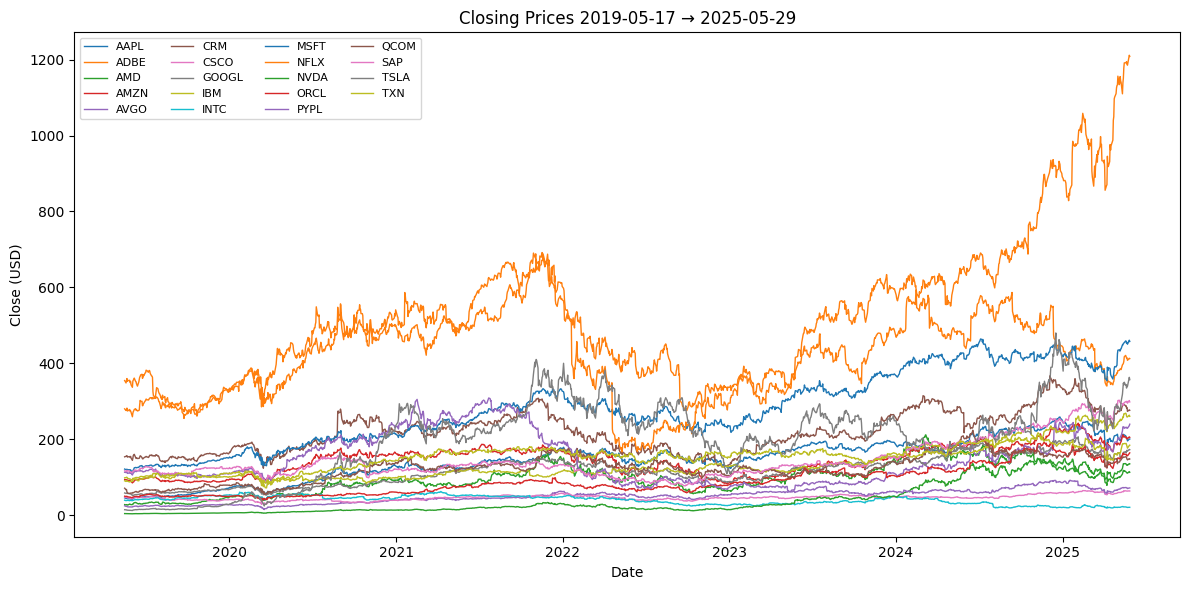

In [9]:
plt.figure(figsize=(12, 6))
for col in close_px.columns:
    plt.plot(close_px.index, close_px[col], lw=1, label=col)
plt.title("Closing Prices 2019-05-17 → 2025-05-29")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

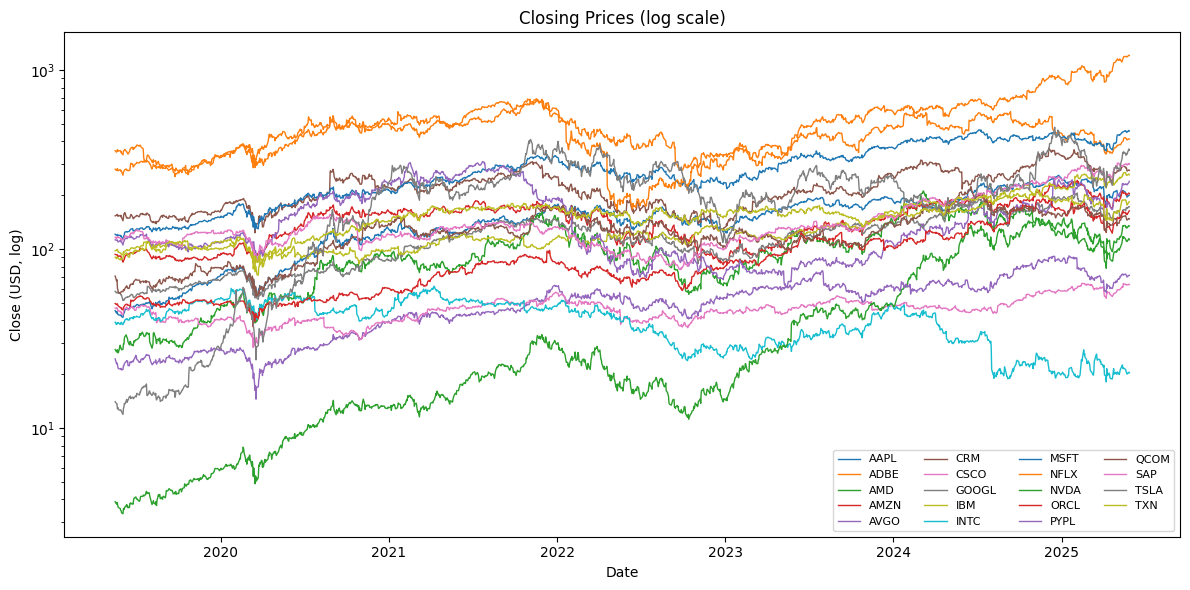

In [10]:
plt.figure(figsize=(12, 6))
for col in close_px.columns:
    plt.semilogy(close_px.index, close_px[col], lw=1, label=col)
plt.title("Closing Prices (log scale)")
plt.xlabel("Date"); plt.ylabel("Close (USD, log)")
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

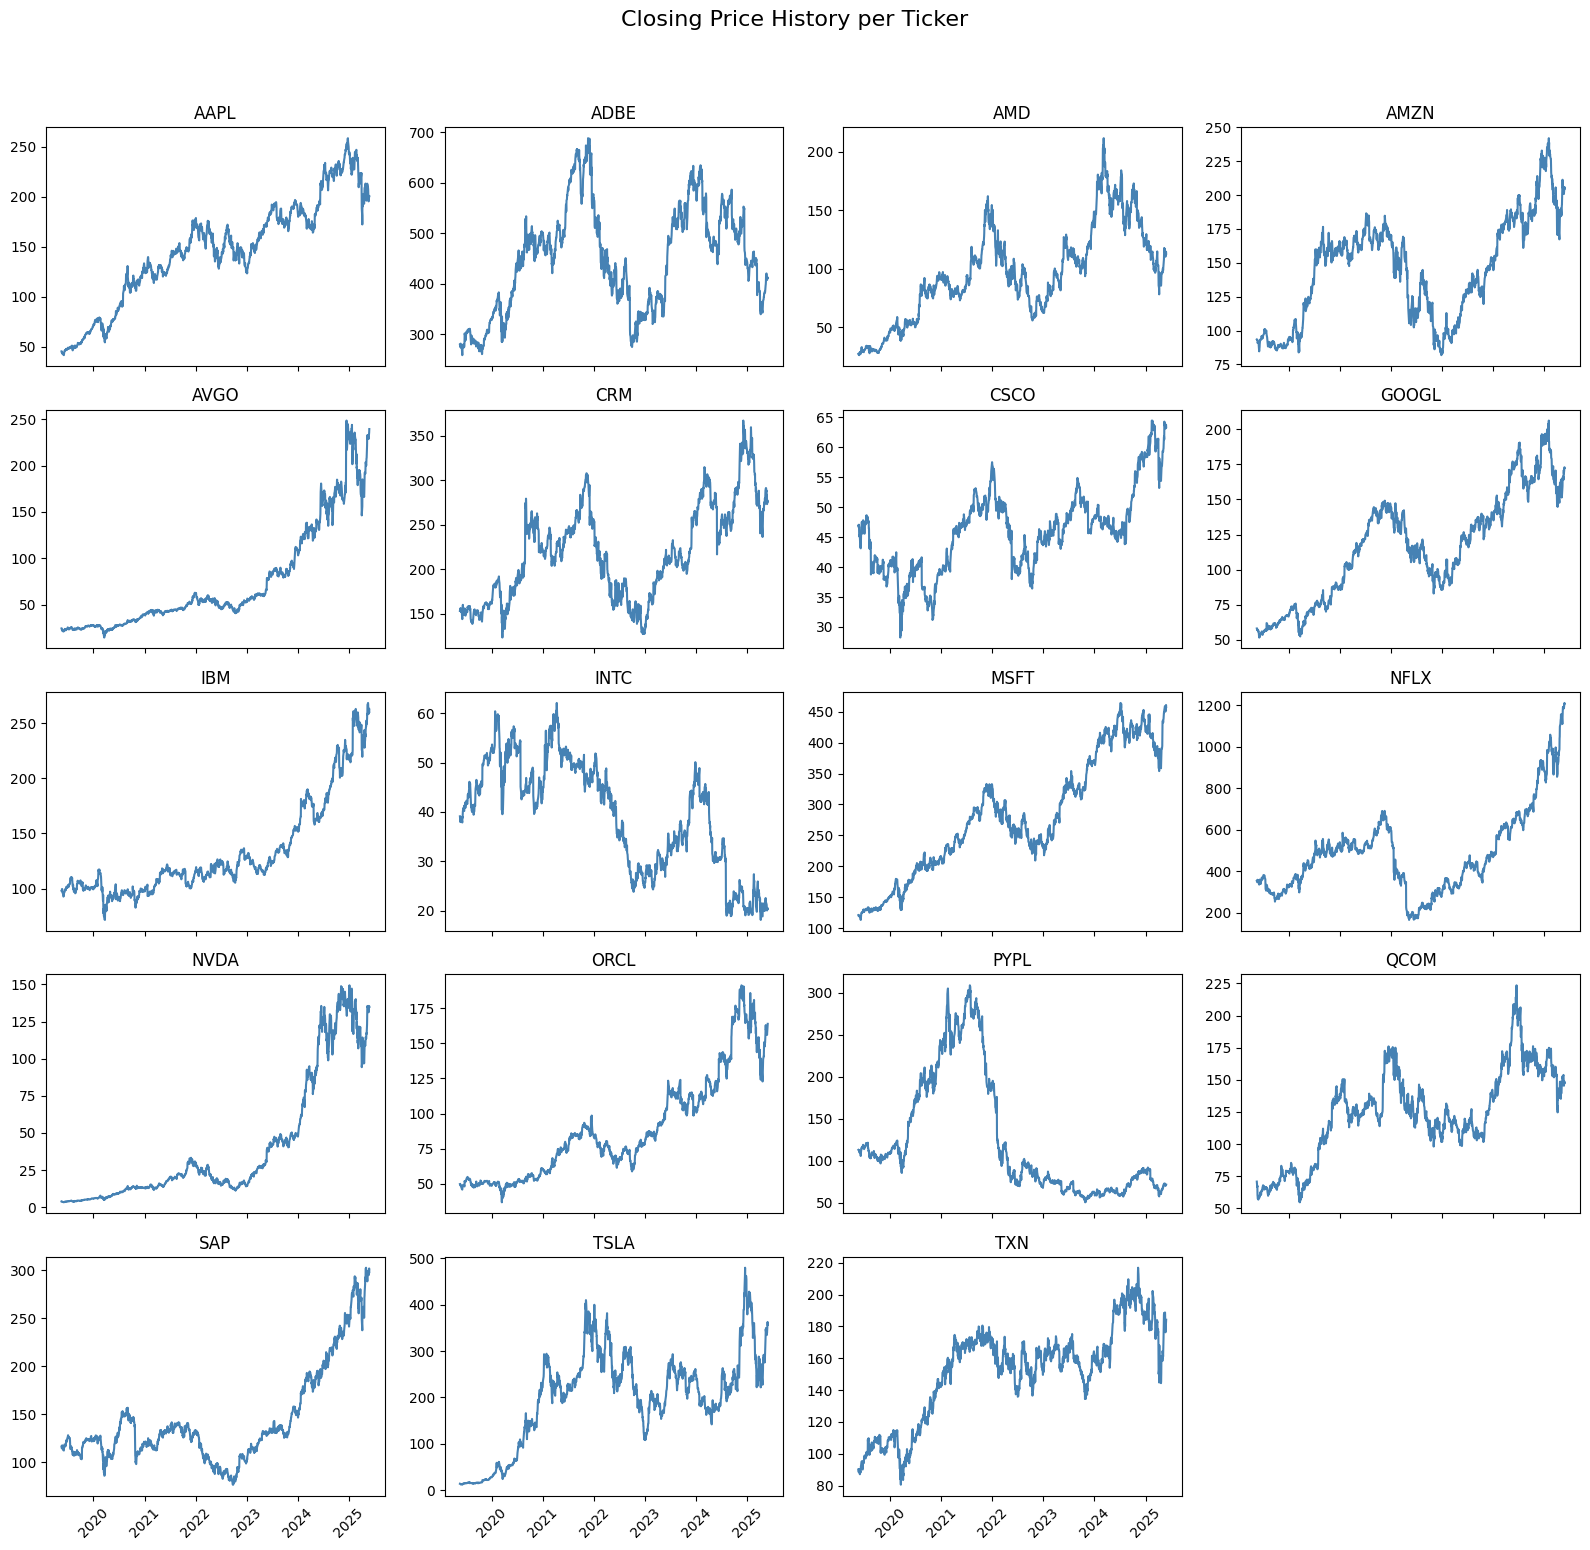

In [11]:
n = close_px.shape[1]
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

for i, col in enumerate(close_px.columns):
    axes[i].plot(close_px.index, close_px[col], color="steelblue")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Closing Price History per Ticker", y=1.03, fontsize=16)
fig.tight_layout()
plt.show()

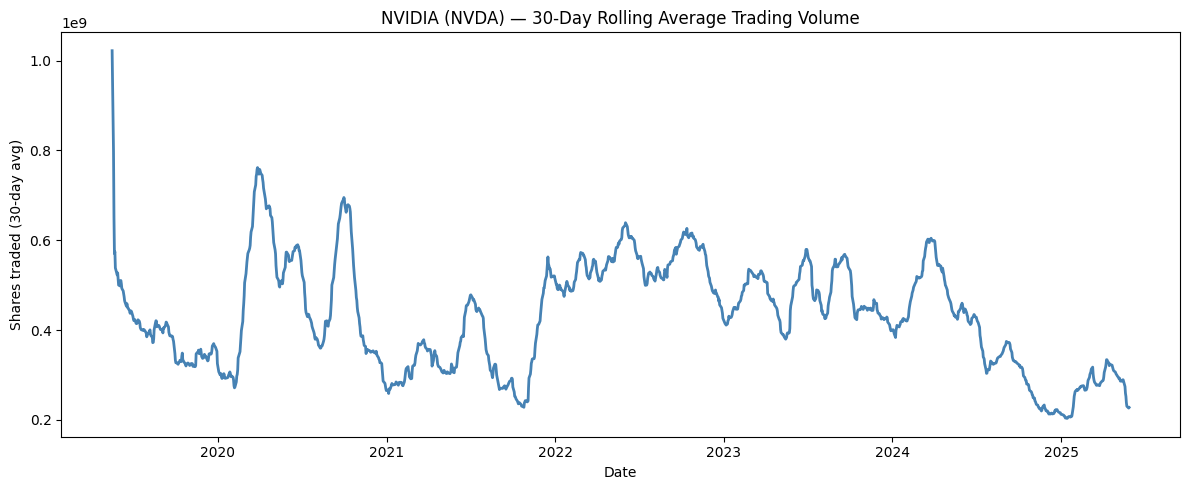

In [12]:
nvda_vol_roll = (
    all_stocks_data
    .query("name == 'NVDA'")
    .set_index("date")["volume"]
    .sort_index()
    .rolling(window=30, min_periods=1)
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(nvda_vol_roll, lw=2, color="steelblue")
plt.title("NVIDIA (NVDA) — 30-Day Rolling Average Trading Volume")
plt.xlabel("Date")
plt.ylabel("Shares traded (30-day avg)")
plt.tight_layout()
plt.show()

Most volatile (by average 30-day std): NFLX


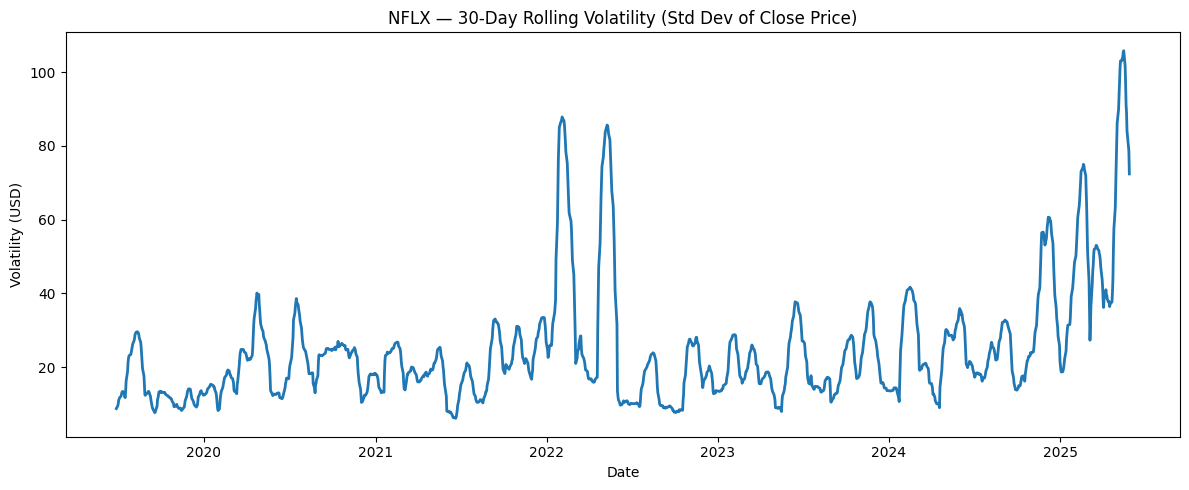

In [13]:
rolling_vol = close_px.rolling(window=30, min_periods=30).std()

avg_vol_per_ticker = rolling_vol.mean()
most_volatile_ticker = avg_vol_per_ticker.idxmax()
print(f"Most volatile (by average 30-day std): {most_volatile_ticker}")

vol_series = rolling_vol[most_volatile_ticker]

plt.figure(figsize=(12, 5))
plt.plot(vol_series, lw=2)
plt.title(f"{most_volatile_ticker} — 30-Day Rolling Volatility (Std Dev of Close Price)")
plt.xlabel("Date")
plt.ylabel("Volatility (USD)")
plt.tight_layout()
plt.show()

Highest average volume: NVDA


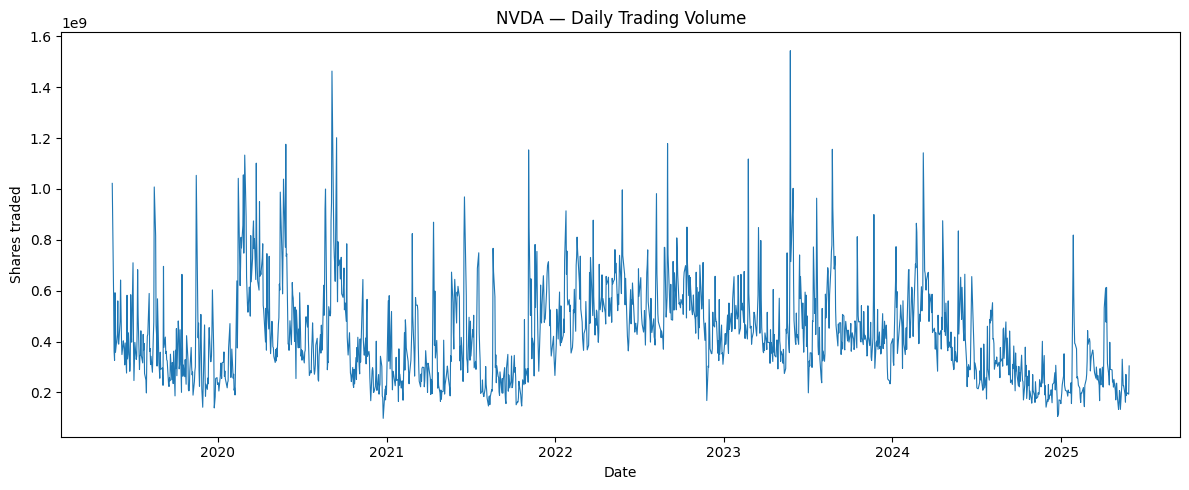

In [14]:
avg_vol = all_stocks_data.groupby("name")["volume"].mean()
top_vol_ticker = avg_vol.idxmax()
print(f"Highest average volume: {top_vol_ticker}")

top_vol_series = (
    all_stocks_data
    .query("name == @top_vol_ticker")
    .set_index("date")["volume"]
    .sort_index()
)

plt.figure(figsize=(12, 5))
plt.plot(top_vol_series, lw=0.8)
plt.title(f"{top_vol_ticker} — Daily Trading Volume")
plt.xlabel("Date")
plt.ylabel("Shares traded")
plt.tight_layout()
plt.show()

### Let's make a model on the Nvidia stock

In [17]:
nvda_close = (
    all_stocks_data
        .query("name == 'NVDA'")
        .set_index("date")["close"]
        .sort_index()
        
)

nvda_close.head()

date
2019-05-17    3.885396
2019-05-20    3.766747
2019-05-21    3.848908
2019-05-22    3.777917
2019-05-23    3.656785
Name: close, dtype: float64